In [1]:
# !pip install imblearn

import os

import pandas as pd
import numpy as np

# Matplotlib for visualization
from matplotlib import pyplot as plt

# display plots in the notebook
%matplotlib inline

# Seaborn for easier visualization
import seaborn as sns

# scikit-learn
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import make_pipeline

# Classification metrics
from sklearn.metrics import confusion_matrix, classification_report

# Function for creating model pipelines - sklearn
from sklearn.pipeline import make_pipeline

# Function for creating model pipelines - imblearn
from imblearn.pipeline import make_pipeline as imbl_pipe

# Over-sampling using SMOTE
from imblearn.over_sampling import SMOTE


In [2]:
abt = pd.read_csv("../Resources/Analytical_Base_Table.csv")
abt.head()

,CustomerID,Gender,Senior_Citizen,Partner,Dependents,Tenure,Phone_Service,Multiple_Lines,Internet_Service,Online_Security,...,Device_Protection,Tech_Support,Streaming_TV,Streaming_Movies,Contract,Paperless_Billing,Payment_Method,Monthly_Charges,Total_Charges,Churn
0,7590-VHVEG,0,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,0
1,5575-GNVDE,1,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,0
2,3668-QPYBK,1,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1
3,7795-CFOCW,1,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,0
4,9237-HQITU,0,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1


## Models Training

## Let's start by splitting our dataframe into separate objects:

y for the target varibale

X for the input features

In [3]:
X = abt.drop(["CustomerID","Churn"], axis=1)

y = abt["Churn"]

# display shapes of X and y
print(X.shape, y.shape)

(6499, 19) (6499,)


In [4]:
# List numerical features
num_colums = X.select_dtypes(include='number').columns.tolist()
num_colums

['Gender', 'Senior_Citizen', 'Tenure', 'Monthly_Charges', 'Total_Charges']

In [5]:
# List categorical features
cat_columns = X.select_dtypes(include='object').columns.tolist()
cat_columns

['Partner',
 'Dependents',
 'Phone_Service',
 'Multiple_Lines',
 'Internet_Service',
 'Online_Security',
 'Online_Backup',
 'Device_Protection',
 'Tech_Support',
 'Streaming_TV',
 'Streaming_Movies',
 'Contract',
 'Paperless_Billing',
 'Payment_Method']

In [6]:
# distribution of churn
col1 = y.value_counts()
col2 = y.value_counts(normalize=True)*100
pd.DataFrame(data={'Target':[0,1],'Churn':col1,'Churn %':col2.round(2)})

,Target,Churn,Churn %
0,0,4784,73.61
1,1,1715,26.39


## Create a Train Test Split

We will continue with splitting our data into separate training and test sets.

30% of observations will be set aside for the test set

the rest, 70%, will be used as the training set

In [7]:
random_state = 10

# Split X and y into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.3,
                                                    random_state=random_state,
                                                    stratify=abt.Churn)

# Print number of observations in X_train, X_test, y_train, and y_test
print(len(X_train), len(X_test), len(y_train), len(y_test))

4549 1950 4549 1950


In [8]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4549 entries, 736 to 5374
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Gender             4549 non-null   int64  
 1   Senior_Citizen     4549 non-null   int64  
 2   Partner            4549 non-null   object 
 3   Dependents         4549 non-null   object 
 4   Tenure             4549 non-null   int64  
 5   Phone_Service      4549 non-null   object 
 6   Multiple_Lines     4549 non-null   object 
 7   Internet_Service   4549 non-null   object 
 8   Online_Security    4549 non-null   object 
 9   Online_Backup      4549 non-null   object 
 10  Device_Protection  4549 non-null   object 
 11  Tech_Support       4549 non-null   object 
 12  Streaming_TV       4549 non-null   object 
 13  Streaming_Movies   4549 non-null   object 
 14  Contract           4549 non-null   object 
 15  Paperless_Billing  4549 non-null   object 
 16  Payment_Method     454

## Pre-processing Pipeline
 
 ##Scale numerical data and encode categorical data
Construct a pre-processing pipeline from the given transformers: MinMaxScaler and OneHotEncoder Create lists of indexes from the list of column namesNeed to be numeric not string to specify columns name in column transformer

In [9]:
num_features = [] 

for i in num_colums:
    location = X.columns.get_loc(i)
    num_features.append(location)
print(num_features)  

[0, 1, 4, 17, 18]


In [10]:
cat_features = []

for i in cat_columns:
    location = X.columns.get_loc(i)
    cat_features.append(location)
print(cat_features) 

[2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]


In [11]:
# Define column transformer
# Need to be numeric not string to specify columns name 
preprocess = make_column_transformer(
    (MinMaxScaler(), num_features),
    (OneHotEncoder(sparse=False), cat_features)
)
preprocess

ColumnTransformer(transformers=[('minmaxscaler', MinMaxScaler(),
                                 [0, 1, 4, 17, 18]),
                                ('onehotencoder', OneHotEncoder(sparse=False),
                                 [2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15,
                                  16])])

In [12]:
# Import classifier
from sklearn.linear_model import LogisticRegression 

# Define model with pipeline
model = imbl_pipe(preprocess,
                  SMOTE(sampling_strategy='auto', random_state=random_state),
                  LogisticRegression(random_state=random_state))

model

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('minmaxscaler',
                                                  MinMaxScaler(),
                                                  [0, 1, 4, 17, 18]),
                                                 ('onehotencoder',
                                                  OneHotEncoder(sparse=False),
                                                  [2, 3, 5, 6, 7, 8, 9, 10, 11,
                                                   12, 13, 14, 15, 16])])),
                ('smote', SMOTE(random_state=10)),
                ('logisticregression', LogisticRegression(random_state=10))])

In [13]:
 # Create the GridSearchCV model
# Create the GridSearch estimator along with a parameter object containing the values to adjust
from sklearn.model_selection import GridSearchCV
lr_param_grid = {
    'logisticregression__C' : [0.01, 0.05, 0.1, 0.5, 1, 5],
    'logisticregression__solver' : ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga']
}

lr_grid = GridSearchCV(model, lr_param_grid, verbose=3, cv= 5, scoring='accuracy')

In [14]:
lr_grid.fit(X_train, y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


c:\Users\pavanksu2009\.virtualenvs\Teleco-Churn-Service-AWS-2RWRRrUB\lib\site-packages\sklearn\preprocessing\_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV 1/5] END logisticregression__C=0.01, logisticregression__solver=liblinear;, score=0.758 total time=   0.5s
[CV 2/5] END logisticregression__C=0.01, logisticregression__solver=liblinear;, score=0.733 total time=   0.0s


c:\Users\pavanksu2009\.virtualenvs\Teleco-Churn-Service-AWS-2RWRRrUB\lib\site-packages\sklearn\preprocessing\_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
c:\Users\pavanksu2009\.virtualenvs\Teleco-Churn-Service-AWS-2RWRRrUB\lib\site-packages\sklearn\preprocessing\_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV 3/5] END logisticregression__C=0.01, logisticregression__solver=liblinear;, score=0.727 total time=   0.0s
[CV 4/5] END logisticregression__C=0.01, logisticregression__solver=liblinear;, score=0.731 total time=   0.0s


c:\Users\pavanksu2009\.virtualenvs\Teleco-Churn-Service-AWS-2RWRRrUB\lib\site-packages\sklearn\preprocessing\_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
c:\Users\pavanksu2009\.virtualenvs\Teleco-Churn-Service-AWS-2RWRRrUB\lib\site-packages\sklearn\preprocessing\_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV 5/5] END logisticregression__C=0.01, logisticregression__solver=liblinear;, score=0.756 total time=   0.1s


c:\Users\pavanksu2009\.virtualenvs\Teleco-Churn-Service-AWS-2RWRRrUB\lib\site-packages\sklearn\preprocessing\_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV 1/5] END logisticregression__C=0.01, logisticregression__solver=newton-cg;, score=0.760 total time=   0.1s


c:\Users\pavanksu2009\.virtualenvs\Teleco-Churn-Service-AWS-2RWRRrUB\lib\site-packages\sklearn\preprocessing\_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV 2/5] END logisticregression__C=0.01, logisticregression__solver=newton-cg;, score=0.734 total time=   0.1s


c:\Users\pavanksu2009\.virtualenvs\Teleco-Churn-Service-AWS-2RWRRrUB\lib\site-packages\sklearn\preprocessing\_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV 3/5] END logisticregression__C=0.01, logisticregression__solver=newton-cg;, score=0.729 total time=   0.1s


c:\Users\pavanksu2009\.virtualenvs\Teleco-Churn-Service-AWS-2RWRRrUB\lib\site-packages\sklearn\preprocessing\_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV 4/5] END logisticregression__C=0.01, logisticregression__solver=newton-cg;, score=0.731 total time=   0.1s
[CV 5/5] END logisticregression__C=0.01, logisticregression__solver=newton-cg;, score=0.760 total time=   0.1s


c:\Users\pavanksu2009\.virtualenvs\Teleco-Churn-Service-AWS-2RWRRrUB\lib\site-packages\sklearn\preprocessing\_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
c:\Users\pavanksu2009\.virtualenvs\Teleco-Churn-Service-AWS-2RWRRrUB\lib\site-packages\sklearn\preprocessing\_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
c:\Users\pavanksu2009\.virtualenvs\Teleco-Churn-Service-AWS-2RWRRrUB\lib\site-packages\sklearn\preprocessing\_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV 1/5] END logisticregression__C=0.01, logisticregression__solver=lbfgs;, score=0.760 total time=   0.0s
[CV 2/5] END logisticregression__C=0.01, logisticregression__solver=lbfgs;, score=0.734 total time=   0.0s


c:\Users\pavanksu2009\.virtualenvs\Teleco-Churn-Service-AWS-2RWRRrUB\lib\site-packages\sklearn\preprocessing\_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
c:\Users\pavanksu2009\.virtualenvs\Teleco-Churn-Service-AWS-2RWRRrUB\lib\site-packages\sklearn\preprocessing\_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV 3/5] END logisticregression__C=0.01, logisticregression__solver=lbfgs;, score=0.729 total time=   0.0s
[CV 4/5] END logisticregression__C=0.01, logisticregression__solver=lbfgs;, score=0.731 total time=   0.0s


c:\Users\pavanksu2009\.virtualenvs\Teleco-Churn-Service-AWS-2RWRRrUB\lib\site-packages\sklearn\preprocessing\_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
c:\Users\pavanksu2009\.virtualenvs\Teleco-Churn-Service-AWS-2RWRRrUB\lib\site-packages\sklearn\preprocessing\_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV 5/5] END logisticregression__C=0.01, logisticregression__solver=lbfgs;, score=0.760 total time=   0.0s
[CV 1/5] END logisticregression__C=0.01, logisticregression__solver=sag;, score=0.760 total time=   0.3s


c:\Users\pavanksu2009\.virtualenvs\Teleco-Churn-Service-AWS-2RWRRrUB\lib\site-packages\sklearn\preprocessing\_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV 2/5] END logisticregression__C=0.01, logisticregression__solver=sag;, score=0.734 total time=   0.1s
[CV 3/5] END logisticregression__C=0.01, logisticregression__solver=sag;, score=0.729 total time=   0.1s


c:\Users\pavanksu2009\.virtualenvs\Teleco-Churn-Service-AWS-2RWRRrUB\lib\site-packages\sklearn\preprocessing\_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
c:\Users\pavanksu2009\.virtualenvs\Teleco-Churn-Service-AWS-2RWRRrUB\lib\site-packages\sklearn\preprocessing\_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV 4/5] END logisticregression__C=0.01, logisticregression__solver=sag;, score=0.731 total time=   0.2s
[CV 5/5] END logisticregression__C=0.01, logisticregression__solver=sag;, score=0.760 total time=   0.1s


c:\Users\pavanksu2009\.virtualenvs\Teleco-Churn-Service-AWS-2RWRRrUB\lib\site-packages\sklearn\preprocessing\_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
c:\Users\pavanksu2009\.virtualenvs\Teleco-Churn-Service-AWS-2RWRRrUB\lib\site-packages\sklearn\preprocessing\_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV 1/5] END logisticregression__C=0.01, logisticregression__solver=saga;, score=0.760 total time=   0.2s


c:\Users\pavanksu2009\.virtualenvs\Teleco-Churn-Service-AWS-2RWRRrUB\lib\site-packages\sklearn\preprocessing\_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV 2/5] END logisticregression__C=0.01, logisticregression__solver=saga;, score=0.734 total time=   0.2s


c:\Users\pavanksu2009\.virtualenvs\Teleco-Churn-Service-AWS-2RWRRrUB\lib\site-packages\sklearn\preprocessing\_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV 3/5] END logisticregression__C=0.01, logisticregression__solver=saga;, score=0.729 total time=   0.1s


c:\Users\pavanksu2009\.virtualenvs\Teleco-Churn-Service-AWS-2RWRRrUB\lib\site-packages\sklearn\preprocessing\_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV 4/5] END logisticregression__C=0.01, logisticregression__solver=saga;, score=0.731 total time=   0.2s


c:\Users\pavanksu2009\.virtualenvs\Teleco-Churn-Service-AWS-2RWRRrUB\lib\site-packages\sklearn\preprocessing\_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV 5/5] END logisticregression__C=0.01, logisticregression__solver=saga;, score=0.760 total time=   0.2s
[CV 1/5] END logisticregression__C=0.05, logisticregression__solver=liblinear;, score=0.759 total time=   0.0s


c:\Users\pavanksu2009\.virtualenvs\Teleco-Churn-Service-AWS-2RWRRrUB\lib\site-packages\sklearn\preprocessing\_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
c:\Users\pavanksu2009\.virtualenvs\Teleco-Churn-Service-AWS-2RWRRrUB\lib\site-packages\sklearn\preprocessing\_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV 2/5] END logisticregression__C=0.05, logisticregression__solver=liblinear;, score=0.742 total time=   0.0s
[CV 3/5] END logisticregression__C=0.05, logisticregression__solver=liblinear;, score=0.732 total time=   0.1s


c:\Users\pavanksu2009\.virtualenvs\Teleco-Churn-Service-AWS-2RWRRrUB\lib\site-packages\sklearn\preprocessing\_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
c:\Users\pavanksu2009\.virtualenvs\Teleco-Churn-Service-AWS-2RWRRrUB\lib\site-packages\sklearn\preprocessing\_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV 4/5] END logisticregression__C=0.05, logisticregression__solver=liblinear;, score=0.737 total time=   0.1s
[CV 5/5] END logisticregression__C=0.05, logisticregression__solver=liblinear;, score=0.758 total time=   0.1s


c:\Users\pavanksu2009\.virtualenvs\Teleco-Churn-Service-AWS-2RWRRrUB\lib\site-packages\sklearn\preprocessing\_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
c:\Users\pavanksu2009\.virtualenvs\Teleco-Churn-Service-AWS-2RWRRrUB\lib\site-packages\sklearn\preprocessing\_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV 1/5] END logisticregression__C=0.05, logisticregression__solver=newton-cg;, score=0.759 total time=   0.2s


c:\Users\pavanksu2009\.virtualenvs\Teleco-Churn-Service-AWS-2RWRRrUB\lib\site-packages\sklearn\preprocessing\_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV 2/5] END logisticregression__C=0.05, logisticregression__solver=newton-cg;, score=0.741 total time=   0.1s


c:\Users\pavanksu2009\.virtualenvs\Teleco-Churn-Service-AWS-2RWRRrUB\lib\site-packages\sklearn\preprocessing\_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV 3/5] END logisticregression__C=0.05, logisticregression__solver=newton-cg;, score=0.731 total time=   0.2s


c:\Users\pavanksu2009\.virtualenvs\Teleco-Churn-Service-AWS-2RWRRrUB\lib\site-packages\sklearn\preprocessing\_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV 4/5] END logisticregression__C=0.05, logisticregression__solver=newton-cg;, score=0.737 total time=   0.2s


c:\Users\pavanksu2009\.virtualenvs\Teleco-Churn-Service-AWS-2RWRRrUB\lib\site-packages\sklearn\preprocessing\_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV 5/5] END logisticregression__C=0.05, logisticregression__solver=newton-cg;, score=0.757 total time=   0.3s
[CV 1/5] END logisticregression__C=0.05, logisticregression__solver=lbfgs;, score=0.759 total time=   0.0s


c:\Users\pavanksu2009\.virtualenvs\Teleco-Churn-Service-AWS-2RWRRrUB\lib\site-packages\sklearn\preprocessing\_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
c:\Users\pavanksu2009\.virtualenvs\Teleco-Churn-Service-AWS-2RWRRrUB\lib\site-packages\sklearn\preprocessing\_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV 2/5] END logisticregression__C=0.05, logisticregression__solver=lbfgs;, score=0.741 total time=   0.1s


c:\Users\pavanksu2009\.virtualenvs\Teleco-Churn-Service-AWS-2RWRRrUB\lib\site-packages\sklearn\preprocessing\_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
c:\Users\pavanksu2009\.virtualenvs\Teleco-Churn-Service-AWS-2RWRRrUB\lib\site-packages\sklearn\preprocessing\_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV 3/5] END logisticregression__C=0.05, logisticregression__solver=lbfgs;, score=0.731 total time=   0.1s
[CV 4/5] END logisticregression__C=0.05, logisticregression__solver=lbfgs;, score=0.737 total time=   0.3s


c:\Users\pavanksu2009\.virtualenvs\Teleco-Churn-Service-AWS-2RWRRrUB\lib\site-packages\sklearn\preprocessing\_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV 5/5] END logisticregression__C=0.05, logisticregression__solver=lbfgs;, score=0.757 total time=   0.1s


c:\Users\pavanksu2009\.virtualenvs\Teleco-Churn-Service-AWS-2RWRRrUB\lib\site-packages\sklearn\preprocessing\_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV 1/5] END logisticregression__C=0.05, logisticregression__solver=sag;, score=0.759 total time=   0.1s


c:\Users\pavanksu2009\.virtualenvs\Teleco-Churn-Service-AWS-2RWRRrUB\lib\site-packages\sklearn\preprocessing\_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV 2/5] END logisticregression__C=0.05, logisticregression__solver=sag;, score=0.741 total time=   0.2s


c:\Users\pavanksu2009\.virtualenvs\Teleco-Churn-Service-AWS-2RWRRrUB\lib\site-packages\sklearn\preprocessing\_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV 3/5] END logisticregression__C=0.05, logisticregression__solver=sag;, score=0.731 total time=   0.3s


c:\Users\pavanksu2009\.virtualenvs\Teleco-Churn-Service-AWS-2RWRRrUB\lib\site-packages\sklearn\preprocessing\_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV 4/5] END logisticregression__C=0.05, logisticregression__solver=sag;, score=0.737 total time=   0.3s


c:\Users\pavanksu2009\.virtualenvs\Teleco-Churn-Service-AWS-2RWRRrUB\lib\site-packages\sklearn\preprocessing\_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV 5/5] END logisticregression__C=0.05, logisticregression__solver=sag;, score=0.757 total time=   0.1s


c:\Users\pavanksu2009\.virtualenvs\Teleco-Churn-Service-AWS-2RWRRrUB\lib\site-packages\sklearn\preprocessing\_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV 1/5] END logisticregression__C=0.05, logisticregression__solver=saga;, score=0.759 total time=   0.2s


c:\Users\pavanksu2009\.virtualenvs\Teleco-Churn-Service-AWS-2RWRRrUB\lib\site-packages\sklearn\preprocessing\_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV 2/5] END logisticregression__C=0.05, logisticregression__solver=saga;, score=0.741 total time=   0.2s


c:\Users\pavanksu2009\.virtualenvs\Teleco-Churn-Service-AWS-2RWRRrUB\lib\site-packages\sklearn\preprocessing\_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV 3/5] END logisticregression__C=0.05, logisticregression__solver=saga;, score=0.731 total time=   0.1s


c:\Users\pavanksu2009\.virtualenvs\Teleco-Churn-Service-AWS-2RWRRrUB\lib\site-packages\sklearn\preprocessing\_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV 4/5] END logisticregression__C=0.05, logisticregression__solver=saga;, score=0.737 total time=   0.1s


c:\Users\pavanksu2009\.virtualenvs\Teleco-Churn-Service-AWS-2RWRRrUB\lib\site-packages\sklearn\preprocessing\_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV 5/5] END logisticregression__C=0.05, logisticregression__solver=saga;, score=0.757 total time=   0.1s
[CV 1/5] END logisticregression__C=0.1, logisticregression__solver=liblinear;, score=0.765 total time=   0.0s


c:\Users\pavanksu2009\.virtualenvs\Teleco-Churn-Service-AWS-2RWRRrUB\lib\site-packages\sklearn\preprocessing\_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
c:\Users\pavanksu2009\.virtualenvs\Teleco-Churn-Service-AWS-2RWRRrUB\lib\site-packages\sklearn\preprocessing\_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV 2/5] END logisticregression__C=0.1, logisticregression__solver=liblinear;, score=0.746 total time=   0.0s
[CV 3/5] END logisticregression__C=0.1, logisticregression__solver=liblinear;, score=0.735 total time=   0.0s


c:\Users\pavanksu2009\.virtualenvs\Teleco-Churn-Service-AWS-2RWRRrUB\lib\site-packages\sklearn\preprocessing\_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
c:\Users\pavanksu2009\.virtualenvs\Teleco-Churn-Service-AWS-2RWRRrUB\lib\site-packages\sklearn\preprocessing\_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV 4/5] END logisticregression__C=0.1, logisticregression__solver=liblinear;, score=0.740 total time=   0.0s
[CV 5/5] END logisticregression__C=0.1, logisticregression__solver=liblinear;, score=0.754 total time=   0.1s


c:\Users\pavanksu2009\.virtualenvs\Teleco-Churn-Service-AWS-2RWRRrUB\lib\site-packages\sklearn\preprocessing\_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
c:\Users\pavanksu2009\.virtualenvs\Teleco-Churn-Service-AWS-2RWRRrUB\lib\site-packages\sklearn\preprocessing\_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV 1/5] END logisticregression__C=0.1, logisticregression__solver=newton-cg;, score=0.765 total time=   0.3s


c:\Users\pavanksu2009\.virtualenvs\Teleco-Churn-Service-AWS-2RWRRrUB\lib\site-packages\sklearn\preprocessing\_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV 2/5] END logisticregression__C=0.1, logisticregression__solver=newton-cg;, score=0.746 total time=   0.2s


c:\Users\pavanksu2009\.virtualenvs\Teleco-Churn-Service-AWS-2RWRRrUB\lib\site-packages\sklearn\preprocessing\_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV 3/5] END logisticregression__C=0.1, logisticregression__solver=newton-cg;, score=0.735 total time=   0.2s


c:\Users\pavanksu2009\.virtualenvs\Teleco-Churn-Service-AWS-2RWRRrUB\lib\site-packages\sklearn\preprocessing\_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV 4/5] END logisticregression__C=0.1, logisticregression__solver=newton-cg;, score=0.740 total time=   0.2s


c:\Users\pavanksu2009\.virtualenvs\Teleco-Churn-Service-AWS-2RWRRrUB\lib\site-packages\sklearn\preprocessing\_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV 5/5] END logisticregression__C=0.1, logisticregression__solver=newton-cg;, score=0.755 total time=   0.1s


c:\Users\pavanksu2009\.virtualenvs\Teleco-Churn-Service-AWS-2RWRRrUB\lib\site-packages\sklearn\preprocessing\_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV 1/5] END logisticregression__C=0.1, logisticregression__solver=lbfgs;, score=0.765 total time=   0.1s
[CV 2/5] END logisticregression__C=0.1, logisticregression__solver=lbfgs;, score=0.746 total time=   0.1s


c:\Users\pavanksu2009\.virtualenvs\Teleco-Churn-Service-AWS-2RWRRrUB\lib\site-packages\sklearn\preprocessing\_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
c:\Users\pavanksu2009\.virtualenvs\Teleco-Churn-Service-AWS-2RWRRrUB\lib\site-packages\sklearn\preprocessing\_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV 3/5] END logisticregression__C=0.1, logisticregression__solver=lbfgs;, score=0.735 total time=   0.1s
[CV 4/5] END logisticregression__C=0.1, logisticregression__solver=lbfgs;, score=0.740 total time=   0.1s


c:\Users\pavanksu2009\.virtualenvs\Teleco-Churn-Service-AWS-2RWRRrUB\lib\site-packages\sklearn\preprocessing\_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
c:\Users\pavanksu2009\.virtualenvs\Teleco-Churn-Service-AWS-2RWRRrUB\lib\site-packages\sklearn\preprocessing\_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV 5/5] END logisticregression__C=0.1, logisticregression__solver=lbfgs;, score=0.755 total time=   0.1s


c:\Users\pavanksu2009\.virtualenvs\Teleco-Churn-Service-AWS-2RWRRrUB\lib\site-packages\sklearn\preprocessing\_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV 1/5] END logisticregression__C=0.1, logisticregression__solver=sag;, score=0.765 total time=   0.1s


c:\Users\pavanksu2009\.virtualenvs\Teleco-Churn-Service-AWS-2RWRRrUB\lib\site-packages\sklearn\preprocessing\_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV 2/5] END logisticregression__C=0.1, logisticregression__solver=sag;, score=0.746 total time=   0.1s


c:\Users\pavanksu2009\.virtualenvs\Teleco-Churn-Service-AWS-2RWRRrUB\lib\site-packages\sklearn\preprocessing\_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV 3/5] END logisticregression__C=0.1, logisticregression__solver=sag;, score=0.735 total time=   0.1s


c:\Users\pavanksu2009\.virtualenvs\Teleco-Churn-Service-AWS-2RWRRrUB\lib\site-packages\sklearn\preprocessing\_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV 4/5] END logisticregression__C=0.1, logisticregression__solver=sag;, score=0.740 total time=   0.1s


c:\Users\pavanksu2009\.virtualenvs\Teleco-Churn-Service-AWS-2RWRRrUB\lib\site-packages\sklearn\preprocessing\_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV 5/5] END logisticregression__C=0.1, logisticregression__solver=sag;, score=0.755 total time=   0.1s


c:\Users\pavanksu2009\.virtualenvs\Teleco-Churn-Service-AWS-2RWRRrUB\lib\site-packages\sklearn\preprocessing\_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV 1/5] END logisticregression__C=0.1, logisticregression__solver=saga;, score=0.765 total time=   0.2s


c:\Users\pavanksu2009\.virtualenvs\Teleco-Churn-Service-AWS-2RWRRrUB\lib\site-packages\sklearn\preprocessing\_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV 2/5] END logisticregression__C=0.1, logisticregression__solver=saga;, score=0.746 total time=   0.2s


c:\Users\pavanksu2009\.virtualenvs\Teleco-Churn-Service-AWS-2RWRRrUB\lib\site-packages\sklearn\preprocessing\_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV 3/5] END logisticregression__C=0.1, logisticregression__solver=saga;, score=0.735 total time=   0.1s


c:\Users\pavanksu2009\.virtualenvs\Teleco-Churn-Service-AWS-2RWRRrUB\lib\site-packages\sklearn\preprocessing\_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV 4/5] END logisticregression__C=0.1, logisticregression__solver=saga;, score=0.740 total time=   0.2s


c:\Users\pavanksu2009\.virtualenvs\Teleco-Churn-Service-AWS-2RWRRrUB\lib\site-packages\sklearn\preprocessing\_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV 5/5] END logisticregression__C=0.1, logisticregression__solver=saga;, score=0.755 total time=   0.1s
[CV 1/5] END logisticregression__C=0.5, logisticregression__solver=liblinear;, score=0.765 total time=   0.0s


c:\Users\pavanksu2009\.virtualenvs\Teleco-Churn-Service-AWS-2RWRRrUB\lib\site-packages\sklearn\preprocessing\_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
c:\Users\pavanksu2009\.virtualenvs\Teleco-Churn-Service-AWS-2RWRRrUB\lib\site-packages\sklearn\preprocessing\_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV 2/5] END logisticregression__C=0.5, logisticregression__solver=liblinear;, score=0.753 total time=   0.0s
[CV 3/5] END logisticregression__C=0.5, logisticregression__solver=liblinear;, score=0.738 total time=   0.0s


c:\Users\pavanksu2009\.virtualenvs\Teleco-Churn-Service-AWS-2RWRRrUB\lib\site-packages\sklearn\preprocessing\_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
c:\Users\pavanksu2009\.virtualenvs\Teleco-Churn-Service-AWS-2RWRRrUB\lib\site-packages\sklearn\preprocessing\_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV 4/5] END logisticregression__C=0.5, logisticregression__solver=liblinear;, score=0.743 total time=   0.0s
[CV 5/5] END logisticregression__C=0.5, logisticregression__solver=liblinear;, score=0.756 total time=   0.0s


c:\Users\pavanksu2009\.virtualenvs\Teleco-Churn-Service-AWS-2RWRRrUB\lib\site-packages\sklearn\preprocessing\_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
c:\Users\pavanksu2009\.virtualenvs\Teleco-Churn-Service-AWS-2RWRRrUB\lib\site-packages\sklearn\preprocessing\_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV 1/5] END logisticregression__C=0.5, logisticregression__solver=newton-cg;, score=0.765 total time=   0.3s


c:\Users\pavanksu2009\.virtualenvs\Teleco-Churn-Service-AWS-2RWRRrUB\lib\site-packages\sklearn\preprocessing\_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV 2/5] END logisticregression__C=0.5, logisticregression__solver=newton-cg;, score=0.753 total time=   0.2s


c:\Users\pavanksu2009\.virtualenvs\Teleco-Churn-Service-AWS-2RWRRrUB\lib\site-packages\sklearn\preprocessing\_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV 3/5] END logisticregression__C=0.5, logisticregression__solver=newton-cg;, score=0.738 total time=   0.1s


c:\Users\pavanksu2009\.virtualenvs\Teleco-Churn-Service-AWS-2RWRRrUB\lib\site-packages\sklearn\preprocessing\_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV 4/5] END logisticregression__C=0.5, logisticregression__solver=newton-cg;, score=0.743 total time=   0.2s


c:\Users\pavanksu2009\.virtualenvs\Teleco-Churn-Service-AWS-2RWRRrUB\lib\site-packages\sklearn\preprocessing\_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV 5/5] END logisticregression__C=0.5, logisticregression__solver=newton-cg;, score=0.756 total time=   0.2s
[CV 1/5] END logisticregression__C=0.5, logisticregression__solver=lbfgs;, score=0.765 total time=   0.0s


c:\Users\pavanksu2009\.virtualenvs\Teleco-Churn-Service-AWS-2RWRRrUB\lib\site-packages\sklearn\preprocessing\_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
c:\Users\pavanksu2009\.virtualenvs\Teleco-Churn-Service-AWS-2RWRRrUB\lib\site-packages\sklearn\preprocessing\_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV 2/5] END logisticregression__C=0.5, logisticregression__solver=lbfgs;, score=0.753 total time=   0.0s
[CV 3/5] END logisticregression__C=0.5, logisticregression__solver=lbfgs;, score=0.738 total time=   0.0s


c:\Users\pavanksu2009\.virtualenvs\Teleco-Churn-Service-AWS-2RWRRrUB\lib\site-packages\sklearn\preprocessing\_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
c:\Users\pavanksu2009\.virtualenvs\Teleco-Churn-Service-AWS-2RWRRrUB\lib\site-packages\sklearn\preprocessing\_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV 4/5] END logisticregression__C=0.5, logisticregression__solver=lbfgs;, score=0.743 total time=   0.0s
[CV 5/5] END logisticregression__C=0.5, logisticregression__solver=lbfgs;, score=0.756 total time=   0.0s


c:\Users\pavanksu2009\.virtualenvs\Teleco-Churn-Service-AWS-2RWRRrUB\lib\site-packages\sklearn\preprocessing\_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
c:\Users\pavanksu2009\.virtualenvs\Teleco-Churn-Service-AWS-2RWRRrUB\lib\site-packages\sklearn\preprocessing\_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV 1/5] END logisticregression__C=0.5, logisticregression__solver=sag;, score=0.765 total time=   0.1s


c:\Users\pavanksu2009\.virtualenvs\Teleco-Churn-Service-AWS-2RWRRrUB\lib\site-packages\sklearn\preprocessing\_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV 2/5] END logisticregression__C=0.5, logisticregression__solver=sag;, score=0.753 total time=   0.1s


c:\Users\pavanksu2009\.virtualenvs\Teleco-Churn-Service-AWS-2RWRRrUB\lib\site-packages\sklearn\preprocessing\_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV 3/5] END logisticregression__C=0.5, logisticregression__solver=sag;, score=0.738 total time=   0.1s


c:\Users\pavanksu2009\.virtualenvs\Teleco-Churn-Service-AWS-2RWRRrUB\lib\site-packages\sklearn\preprocessing\_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV 4/5] END logisticregression__C=0.5, logisticregression__solver=sag;, score=0.743 total time=   0.1s
[CV 5/5] END logisticregression__C=0.5, logisticregression__solver=sag;, score=0.756 total time=   0.1s


c:\Users\pavanksu2009\.virtualenvs\Teleco-Churn-Service-AWS-2RWRRrUB\lib\site-packages\sklearn\preprocessing\_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
c:\Users\pavanksu2009\.virtualenvs\Teleco-Churn-Service-AWS-2RWRRrUB\lib\site-packages\sklearn\preprocessing\_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV 1/5] END logisticregression__C=0.5, logisticregression__solver=saga;, score=0.765 total time=   0.1s
[CV 2/5] END logisticregression__C=0.5, logisticregression__solver=saga;, score=0.753 total time=   0.1s


c:\Users\pavanksu2009\.virtualenvs\Teleco-Churn-Service-AWS-2RWRRrUB\lib\site-packages\sklearn\preprocessing\_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
c:\Users\pavanksu2009\.virtualenvs\Teleco-Churn-Service-AWS-2RWRRrUB\lib\site-packages\sklearn\preprocessing\_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV 3/5] END logisticregression__C=0.5, logisticregression__solver=saga;, score=0.738 total time=   0.1s


c:\Users\pavanksu2009\.virtualenvs\Teleco-Churn-Service-AWS-2RWRRrUB\lib\site-packages\sklearn\preprocessing\_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV 4/5] END logisticregression__C=0.5, logisticregression__solver=saga;, score=0.743 total time=   0.1s


c:\Users\pavanksu2009\.virtualenvs\Teleco-Churn-Service-AWS-2RWRRrUB\lib\site-packages\sklearn\preprocessing\_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV 5/5] END logisticregression__C=0.5, logisticregression__solver=saga;, score=0.756 total time=   0.1s
[CV 1/5] END logisticregression__C=1, logisticregression__solver=liblinear;, score=0.759 total time=   0.0s


c:\Users\pavanksu2009\.virtualenvs\Teleco-Churn-Service-AWS-2RWRRrUB\lib\site-packages\sklearn\preprocessing\_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
c:\Users\pavanksu2009\.virtualenvs\Teleco-Churn-Service-AWS-2RWRRrUB\lib\site-packages\sklearn\preprocessing\_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV 2/5] END logisticregression__C=1, logisticregression__solver=liblinear;, score=0.752 total time=   0.0s
[CV 3/5] END logisticregression__C=1, logisticregression__solver=liblinear;, score=0.735 total time=   0.0s


c:\Users\pavanksu2009\.virtualenvs\Teleco-Churn-Service-AWS-2RWRRrUB\lib\site-packages\sklearn\preprocessing\_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
c:\Users\pavanksu2009\.virtualenvs\Teleco-Churn-Service-AWS-2RWRRrUB\lib\site-packages\sklearn\preprocessing\_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV 4/5] END logisticregression__C=1, logisticregression__solver=liblinear;, score=0.742 total time=   0.0s
[CV 5/5] END logisticregression__C=1, logisticregression__solver=liblinear;, score=0.757 total time=   0.0s


c:\Users\pavanksu2009\.virtualenvs\Teleco-Churn-Service-AWS-2RWRRrUB\lib\site-packages\sklearn\preprocessing\_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
c:\Users\pavanksu2009\.virtualenvs\Teleco-Churn-Service-AWS-2RWRRrUB\lib\site-packages\sklearn\preprocessing\_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV 1/5] END logisticregression__C=1, logisticregression__solver=newton-cg;, score=0.759 total time=   0.1s


c:\Users\pavanksu2009\.virtualenvs\Teleco-Churn-Service-AWS-2RWRRrUB\lib\site-packages\sklearn\preprocessing\_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV 2/5] END logisticregression__C=1, logisticregression__solver=newton-cg;, score=0.752 total time=   0.1s
[CV 3/5] END logisticregression__C=1, logisticregression__solver=newton-cg;, score=0.735 total time=   0.1s


c:\Users\pavanksu2009\.virtualenvs\Teleco-Churn-Service-AWS-2RWRRrUB\lib\site-packages\sklearn\preprocessing\_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
c:\Users\pavanksu2009\.virtualenvs\Teleco-Churn-Service-AWS-2RWRRrUB\lib\site-packages\sklearn\preprocessing\_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV 4/5] END logisticregression__C=1, logisticregression__solver=newton-cg;, score=0.742 total time=   0.1s
[CV 5/5] END logisticregression__C=1, logisticregression__solver=newton-cg;, score=0.757 total time=   0.1s


c:\Users\pavanksu2009\.virtualenvs\Teleco-Churn-Service-AWS-2RWRRrUB\lib\site-packages\sklearn\preprocessing\_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
c:\Users\pavanksu2009\.virtualenvs\Teleco-Churn-Service-AWS-2RWRRrUB\lib\site-packages\sklearn\preprocessing\_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV 1/5] END logisticregression__C=1, logisticregression__solver=lbfgs;, score=0.759 total time=   0.0s
[CV 2/5] END logisticregression__C=1, logisticregression__solver=lbfgs;, score=0.752 total time=   0.0s


c:\Users\pavanksu2009\.virtualenvs\Teleco-Churn-Service-AWS-2RWRRrUB\lib\site-packages\sklearn\preprocessing\_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
c:\Users\pavanksu2009\.virtualenvs\Teleco-Churn-Service-AWS-2RWRRrUB\lib\site-packages\sklearn\preprocessing\_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV 3/5] END logisticregression__C=1, logisticregression__solver=lbfgs;, score=0.735 total time=   0.0s
[CV 4/5] END logisticregression__C=1, logisticregression__solver=lbfgs;, score=0.742 total time=   0.0s


c:\Users\pavanksu2009\.virtualenvs\Teleco-Churn-Service-AWS-2RWRRrUB\lib\site-packages\sklearn\preprocessing\_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
c:\Users\pavanksu2009\.virtualenvs\Teleco-Churn-Service-AWS-2RWRRrUB\lib\site-packages\sklearn\preprocessing\_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV 5/5] END logisticregression__C=1, logisticregression__solver=lbfgs;, score=0.757 total time=   0.0s


c:\Users\pavanksu2009\.virtualenvs\Teleco-Churn-Service-AWS-2RWRRrUB\lib\site-packages\sklearn\preprocessing\_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV 1/5] END logisticregression__C=1, logisticregression__solver=sag;, score=0.759 total time=   0.1s


c:\Users\pavanksu2009\.virtualenvs\Teleco-Churn-Service-AWS-2RWRRrUB\lib\site-packages\sklearn\preprocessing\_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV 2/5] END logisticregression__C=1, logisticregression__solver=sag;, score=0.752 total time=   0.1s


c:\Users\pavanksu2009\.virtualenvs\Teleco-Churn-Service-AWS-2RWRRrUB\lib\site-packages\sklearn\preprocessing\_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV 3/5] END logisticregression__C=1, logisticregression__solver=sag;, score=0.735 total time=   0.2s


c:\Users\pavanksu2009\.virtualenvs\Teleco-Churn-Service-AWS-2RWRRrUB\lib\site-packages\sklearn\preprocessing\_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV 4/5] END logisticregression__C=1, logisticregression__solver=sag;, score=0.742 total time=   0.2s


c:\Users\pavanksu2009\.virtualenvs\Teleco-Churn-Service-AWS-2RWRRrUB\lib\site-packages\sklearn\preprocessing\_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV 5/5] END logisticregression__C=1, logisticregression__solver=sag;, score=0.757 total time=   0.1s


c:\Users\pavanksu2009\.virtualenvs\Teleco-Churn-Service-AWS-2RWRRrUB\lib\site-packages\sklearn\preprocessing\_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV 1/5] END logisticregression__C=1, logisticregression__solver=saga;, score=0.759 total time=   0.2s


c:\Users\pavanksu2009\.virtualenvs\Teleco-Churn-Service-AWS-2RWRRrUB\lib\site-packages\sklearn\preprocessing\_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV 2/5] END logisticregression__C=1, logisticregression__solver=saga;, score=0.752 total time=   0.2s


c:\Users\pavanksu2009\.virtualenvs\Teleco-Churn-Service-AWS-2RWRRrUB\lib\site-packages\sklearn\preprocessing\_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV 3/5] END logisticregression__C=1, logisticregression__solver=saga;, score=0.735 total time=   0.2s


c:\Users\pavanksu2009\.virtualenvs\Teleco-Churn-Service-AWS-2RWRRrUB\lib\site-packages\sklearn\preprocessing\_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV 4/5] END logisticregression__C=1, logisticregression__solver=saga;, score=0.742 total time=   0.2s


c:\Users\pavanksu2009\.virtualenvs\Teleco-Churn-Service-AWS-2RWRRrUB\lib\site-packages\sklearn\preprocessing\_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV 5/5] END logisticregression__C=1, logisticregression__solver=saga;, score=0.757 total time=   0.2s
[CV 1/5] END logisticregression__C=5, logisticregression__solver=liblinear;, score=0.759 total time=   0.0s


c:\Users\pavanksu2009\.virtualenvs\Teleco-Churn-Service-AWS-2RWRRrUB\lib\site-packages\sklearn\preprocessing\_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
c:\Users\pavanksu2009\.virtualenvs\Teleco-Churn-Service-AWS-2RWRRrUB\lib\site-packages\sklearn\preprocessing\_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV 2/5] END logisticregression__C=5, logisticregression__solver=liblinear;, score=0.753 total time=   0.0s
[CV 3/5] END logisticregression__C=5, logisticregression__solver=liblinear;, score=0.731 total time=   0.0s


c:\Users\pavanksu2009\.virtualenvs\Teleco-Churn-Service-AWS-2RWRRrUB\lib\site-packages\sklearn\preprocessing\_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
c:\Users\pavanksu2009\.virtualenvs\Teleco-Churn-Service-AWS-2RWRRrUB\lib\site-packages\sklearn\preprocessing\_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV 4/5] END logisticregression__C=5, logisticregression__solver=liblinear;, score=0.742 total time=   0.0s
[CV 5/5] END logisticregression__C=5, logisticregression__solver=liblinear;, score=0.754 total time=   0.0s


c:\Users\pavanksu2009\.virtualenvs\Teleco-Churn-Service-AWS-2RWRRrUB\lib\site-packages\sklearn\preprocessing\_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
c:\Users\pavanksu2009\.virtualenvs\Teleco-Churn-Service-AWS-2RWRRrUB\lib\site-packages\sklearn\preprocessing\_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV 1/5] END logisticregression__C=5, logisticregression__solver=newton-cg;, score=0.759 total time=   0.1s


c:\Users\pavanksu2009\.virtualenvs\Teleco-Churn-Service-AWS-2RWRRrUB\lib\site-packages\sklearn\preprocessing\_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV 2/5] END logisticregression__C=5, logisticregression__solver=newton-cg;, score=0.753 total time=   0.2s


c:\Users\pavanksu2009\.virtualenvs\Teleco-Churn-Service-AWS-2RWRRrUB\lib\site-packages\sklearn\preprocessing\_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV 3/5] END logisticregression__C=5, logisticregression__solver=newton-cg;, score=0.731 total time=   0.2s


c:\Users\pavanksu2009\.virtualenvs\Teleco-Churn-Service-AWS-2RWRRrUB\lib\site-packages\sklearn\preprocessing\_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV 4/5] END logisticregression__C=5, logisticregression__solver=newton-cg;, score=0.742 total time=   0.2s


c:\Users\pavanksu2009\.virtualenvs\Teleco-Churn-Service-AWS-2RWRRrUB\lib\site-packages\sklearn\preprocessing\_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV 5/5] END logisticregression__C=5, logisticregression__solver=newton-cg;, score=0.754 total time=   0.1s
[CV 1/5] END logisticregression__C=5, logisticregression__solver=lbfgs;, score=0.759 total time=   0.0s


c:\Users\pavanksu2009\.virtualenvs\Teleco-Churn-Service-AWS-2RWRRrUB\lib\site-packages\sklearn\preprocessing\_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
c:\Users\pavanksu2009\.virtualenvs\Teleco-Churn-Service-AWS-2RWRRrUB\lib\site-packages\sklearn\preprocessing\_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV 2/5] END logisticregression__C=5, logisticregression__solver=lbfgs;, score=0.753 total time=   0.0s
[CV 3/5] END logisticregression__C=5, logisticregression__solver=lbfgs;, score=0.731 total time=   0.0s


c:\Users\pavanksu2009\.virtualenvs\Teleco-Churn-Service-AWS-2RWRRrUB\lib\site-packages\sklearn\preprocessing\_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
c:\Users\pavanksu2009\.virtualenvs\Teleco-Churn-Service-AWS-2RWRRrUB\lib\site-packages\sklearn\preprocessing\_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV 4/5] END logisticregression__C=5, logisticregression__solver=lbfgs;, score=0.742 total time=   0.0s
[CV 5/5] END logisticregression__C=5, logisticregression__solver=lbfgs;, score=0.754 total time=   0.0s


c:\Users\pavanksu2009\.virtualenvs\Teleco-Churn-Service-AWS-2RWRRrUB\lib\site-packages\sklearn\preprocessing\_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
c:\Users\pavanksu2009\.virtualenvs\Teleco-Churn-Service-AWS-2RWRRrUB\lib\site-packages\sklearn\preprocessing\_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
c:\Users\pavanksu2009\.virtualenvs\Teleco-Churn-Service-AWS-2RWRRrUB\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\pavanksu2009\.virtualenvs\Teleco-Churn-Service-AWS-2RWRRrUB\lib\site-packages\sklearn\preprocessing\_encoders.py:808: FutureWarning: `s

[CV 1/5] END logisticregression__C=5, logisticregression__solver=sag;, score=0.759 total time=   0.3s
[CV 2/5] END logisticregression__C=5, logisticregression__solver=sag;, score=0.753 total time=   0.3s


c:\Users\pavanksu2009\.virtualenvs\Teleco-Churn-Service-AWS-2RWRRrUB\lib\site-packages\sklearn\preprocessing\_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV 3/5] END logisticregression__C=5, logisticregression__solver=sag;, score=0.731 total time=   0.3s


c:\Users\pavanksu2009\.virtualenvs\Teleco-Churn-Service-AWS-2RWRRrUB\lib\site-packages\sklearn\preprocessing\_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV 4/5] END logisticregression__C=5, logisticregression__solver=sag;, score=0.742 total time=   0.3s


c:\Users\pavanksu2009\.virtualenvs\Teleco-Churn-Service-AWS-2RWRRrUB\lib\site-packages\sklearn\preprocessing\_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
c:\Users\pavanksu2009\.virtualenvs\Teleco-Churn-Service-AWS-2RWRRrUB\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\pavanksu2009\.virtualenvs\Teleco-Churn-Service-AWS-2RWRRrUB\lib\site-packages\sklearn\preprocessing\_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV 5/5] END logisticregression__C=5, logisticregression__solver=sag;, score=0.754 total time=   0.3s


c:\Users\pavanksu2009\.virtualenvs\Teleco-Churn-Service-AWS-2RWRRrUB\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\pavanksu2009\.virtualenvs\Teleco-Churn-Service-AWS-2RWRRrUB\lib\site-packages\sklearn\preprocessing\_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV 1/5] END logisticregression__C=5, logisticregression__solver=saga;, score=0.759 total time=   0.4s


c:\Users\pavanksu2009\.virtualenvs\Teleco-Churn-Service-AWS-2RWRRrUB\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\pavanksu2009\.virtualenvs\Teleco-Churn-Service-AWS-2RWRRrUB\lib\site-packages\sklearn\preprocessing\_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV 2/5] END logisticregression__C=5, logisticregression__solver=saga;, score=0.753 total time=   0.4s


c:\Users\pavanksu2009\.virtualenvs\Teleco-Churn-Service-AWS-2RWRRrUB\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\pavanksu2009\.virtualenvs\Teleco-Churn-Service-AWS-2RWRRrUB\lib\site-packages\sklearn\preprocessing\_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV 3/5] END logisticregression__C=5, logisticregression__solver=saga;, score=0.731 total time=   0.4s


c:\Users\pavanksu2009\.virtualenvs\Teleco-Churn-Service-AWS-2RWRRrUB\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\pavanksu2009\.virtualenvs\Teleco-Churn-Service-AWS-2RWRRrUB\lib\site-packages\sklearn\preprocessing\_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV 4/5] END logisticregression__C=5, logisticregression__solver=saga;, score=0.742 total time=   0.4s
[CV 5/5] END logisticregression__C=5, logisticregression__solver=saga;, score=0.752 total time=   0.4s


c:\Users\pavanksu2009\.virtualenvs\Teleco-Churn-Service-AWS-2RWRRrUB\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\pavanksu2009\.virtualenvs\Teleco-Churn-Service-AWS-2RWRRrUB\lib\site-packages\sklearn\preprocessing\_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('minmaxscaler',
                                                                         MinMaxScaler(),
                                                                         [0, 1,
                                                                          4, 17,
                                                                          18]),
                                                                        ('onehotencoder',
                                                                         OneHotEncoder(sparse=False),
                                                                         [2, 3,
                                                                          5, 6,
                                                                          7, 8,
                                                                          9, 10,
                                                                          11,
                                                                          12,
                                                                          13,
                                                                          14,
                                                                          15,
                                                                          16])])),
                                       ('smote', SMOTE(random_state=10)),
                                       ('logisticregression',
                                        LogisticRegression(random_state=10))]),
             param_grid={'logisticregression__C': [0.01, 0.05, 0.1, 0.5, 1, 5],
                         'logisticregression__solver': ['liblinear',
                                                        'newton-cg', 'lbfgs',
                                                        'sag', 'saga']},
             scoring='accuracy', verbose=3)

In [15]:
print(lr_grid.best_params_)

{'logisticregression__C': 0.5, 'logisticregression__solver': 'liblinear'}


In [16]:
print(lr_grid.best_score_)

0.7509353352917709


In [17]:
print(f"Training Data Score: {lr_grid.score(X_train, y_train)}")
print(f"Testing Data Score: {lr_grid.score(X_test, y_test)}")

Training Data Score: 0.7557704990107716
Testing Data Score: 0.7569230769230769


In [18]:
predictions = lr_grid.predict(X_test)
print(f"First 10 Predictions:   {predictions[:10]}")
print(f"First 10 Actual labels: {y_test[:10].tolist()}")

First 10 Predictions:   [1 1 1 0 0 1 0 0 0 0]
First 10 Actual labels: [1, 0, 1, 0, 0, 1, 0, 0, 0, 0]


C:\Users\pavanksu2009\AppData\Local\Temp\ipykernel_9892\2120681893.py:3: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  print(f"First 10 Actual labels: {y_test[:10].tolist()}")


In [19]:
X_test.iloc[0]

Gender                              0
Senior_Citizen                      1
Partner                            No
Dependents                         No
Tenure                             38
Phone_Service                     Yes
Multiple_Lines                    Yes
Internet_Service          Fiber optic
Online_Security                    No
Online_Backup                      No
Device_Protection                  No
Tech_Support                      Yes
Streaming_TV                      Yes
Streaming_Movies                  Yes
Contract               Month-to-month
Paperless_Billing                 Yes
Payment_Method       Electronic check
Monthly_Charges                 99.55
Total_Charges                 3734.25
Name: 3135, dtype: object

In [20]:
pd.DataFrame({"Prediction": predictions, "Actual": y_test}).reset_index(drop=True)

,Prediction,Actual
0,1,1
1,1,0
2,1,1
3,0,0
4,0,0
...,...,...
1945,0,0
1946,1,1
1947,0,0
1948,0,0


In [21]:
cm = confusion_matrix(y_test, predictions)
print(cm)

[[1065  370]
 [ 104  411]]


In [22]:
cm = np.around(cm / cm.sum(axis=1)[:, np.newaxis], 2)
print(cm)

[[0.74 0.26]
 [0.2  0.8 ]]


In [23]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.91      0.74      0.82      1435
           1       0.53      0.80      0.63       515

    accuracy                           0.76      1950
   macro avg       0.72      0.77      0.73      1950
weighted avg       0.81      0.76      0.77      1950



In [24]:
pred = lr_grid.predict(X_test[:1])

In [25]:
print(f"Predicted classes: {pred}")
print(f"Actual Labels: {list(y_test[:1])}")

Predicted classes: [1]
Actual Labels: [1]


C:\Users\pavanksu2009\AppData\Local\Temp\ipykernel_9892\3302990698.py:2: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  print(f"Actual Labels: {list(y_test[:1])}")


In [26]:
import joblib

filename = '../models/challa_logistic_regression.sav'
joblib.dump(lr_grid, filename)

['../models/challa_logistic_regression.sav']

In [27]:
lr_model = joblib.load(filename)
print(lr_model.score(X_test, y_test))

0.7569230769230769


In [28]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

In [29]:
# defining a function to compute different metrics to check performance of a classification model built using sklearn
def model_performance_classification_sklearn(model, predictors, target):
    """
    Function to compute different metrics to check classification model performance

    model: classifier
    predictors: independent variables
    target: dependent variable
    """

    # predicting using the independent variables
    pred = model.predict(predictors)

    acc = accuracy_score(target, pred)  # to compute Accuracy
    recall = recall_score(target, pred)  # to compute Recall
    precision = precision_score(target, pred)  # to compute Precision
    f1 = f1_score(target, pred)  # to compute F1-score

    # creating a dataframe of metrics
    df_perf = pd.DataFrame(
        {"Accuracy": acc, "Recall": recall, "Precision": precision, "F1": f1,},
        index=[0],
    )

    return df_perf

In [30]:
def confusion_matrix_sklearn(model, predictors, target):
    """
    To plot the confusion_matrix with percentages

    model: classifier
    predictors: independent variables
    target: dependent variable
    """
    y_pred = model.predict(predictors)
    cm = confusion_matrix(target, y_pred)
    labels = np.asarray(
        [
            ["{0:0.0f}".format(item) + "\n{0:.2%}".format(item / cm.flatten().sum())]
            for item in cm.flatten()
        ]
    ).reshape(2, 2)

    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=labels, fmt="")
    plt.ylabel("True label")
    plt.xlabel("Predicted label")

In [31]:
LR_perf_train = model_performance_classification_sklearn(lr_grid, X_train, y_train)
LR_perf_train

,Accuracy,Recall,Precision,F1
0,0.75577,0.795833,0.524437,0.632241


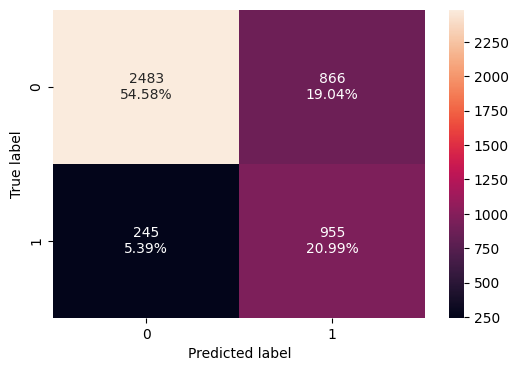

In [32]:
confusion_matrix_sklearn(lr_grid, X_train, y_train)

In [33]:
LR_perf_test = model_performance_classification_sklearn(lr_grid, X_test, y_test)
LR_perf_test

,Accuracy,Recall,Precision,F1
0,0.756923,0.798058,0.526248,0.634259


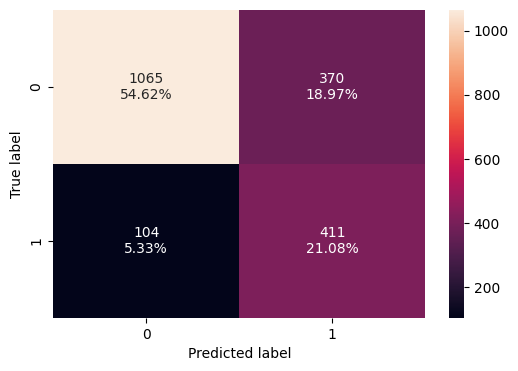

In [34]:
confusion_matrix_sklearn(lr_grid, X_test, y_test)

In [35]:
df1 = pd.DataFrame(model_performance_classification_sklearn(lr_grid, X_test, y_test).T).reset_index().rename(columns={'index':'Metrics_names',0:'Testing_Metrics'})
df1

,Metrics_names,Testing_Metrics
0,Accuracy,0.756923
1,Recall,0.798058
2,Precision,0.526248
3,F1,0.634259


In [36]:
df2 = pd.DataFrame(model_performance_classification_sklearn(lr_grid, X_train, y_train).T).reset_index().rename(columns={'index':'Metrics_names',0:'Training_Metrics'})
df2

,Metrics_names,Training_Metrics
0,Accuracy,0.755770
1,Recall,0.795833
2,Precision,0.524437
3,F1,0.632241


In [37]:
Output_df = pd.merge(df2, df1, on='Metrics_names')
display(Output_df)

,Metrics_names,Training_Metrics,Testing_Metrics
0,Accuracy,0.755770,0.756923
1,Recall,0.795833,0.798058
2,Precision,0.524437,0.526248
3,F1,0.632241,0.634259


In [38]:
print("Churn Probability is {}".format(lr_grid.predict_proba(X_train)[:, 1][0]))

Churn Probability is 0.4472495584832277


In [39]:
X_train

,Gender,Senior_Citizen,Partner,Dependents,Tenure,Phone_Service,Multiple_Lines,Internet_Service,Online_Security,Online_Backup,Device_Protection,Tech_Support,Streaming_TV,Streaming_Movies,Contract,Paperless_Billing,Payment_Method,Monthly_Charges,Total_Charges
736,0,0,No,No,30,Yes,Yes,Fiber optic,No,Yes,Yes,Yes,Yes,Yes,One year,No,Credit card (automatic),110.45,3327.05
411,0,0,Yes,No,46,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,Yes,Bank transfer (automatic),24.45,1066.15
3918,1,0,Yes,Yes,20,Yes,No,Fiber optic,No,No,No,No,Yes,Yes,Month-to-month,Yes,Electronic check,90.20,1776.55
4787,0,0,Yes,No,4,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,No,Mailed check,54.70,235.05
728,0,1,No,No,30,Yes,Yes,Fiber optic,Yes,Yes,Yes,No,No,No,Month-to-month,No,Credit card (automatic),91.70,2758.15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6141,1,1,Yes,No,52,Yes,Yes,Fiber optic,Yes,No,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,104.20,5568.35
5333,0,0,Yes,Yes,13,Yes,No,Fiber optic,No,No,No,No,Yes,Yes,Month-to-month,No,Electronic check,88.35,1222.80
1796,0,0,Yes,No,23,Yes,Yes,DSL,No,No,No,Yes,Yes,Yes,Month-to-month,Yes,Credit card (automatic),73.65,1642.75
339,1,0,Yes,No,63,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,103.40,6603.00


In [40]:
X_train.columns

Index(['Gender', 'Senior_Citizen', 'Partner', 'Dependents', 'Tenure',
       'Phone_Service', 'Multiple_Lines', 'Internet_Service',
       'Online_Security', 'Online_Backup', 'Device_Protection', 'Tech_Support',
       'Streaming_TV', 'Streaming_Movies', 'Contract', 'Paperless_Billing',
       'Payment_Method', 'Monthly_Charges', 'Total_Charges'],
      dtype='object')

In [41]:
x_test = pd.DataFrame([X_train.iloc[10]])
x_test

,Gender,Senior_Citizen,Partner,Dependents,Tenure,Phone_Service,Multiple_Lines,Internet_Service,Online_Security,Online_Backup,Device_Protection,Tech_Support,Streaming_TV,Streaming_Movies,Contract,Paperless_Billing,Payment_Method,Monthly_Charges,Total_Charges
1930,1,0,No,No,3,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,Yes,Electronic check,20.5,76.95


In [42]:
num_colums, cat_columns

(['Gender', 'Senior_Citizen', 'Tenure', 'Monthly_Charges', 'Total_Charges'],
 ['Partner',
  'Dependents',
  'Phone_Service',
  'Multiple_Lines',
  'Internet_Service',
  'Online_Security',
  'Online_Backup',
  'Device_Protection',
  'Tech_Support',
  'Streaming_TV',
  'Streaming_Movies',
  'Contract',
  'Paperless_Billing',
  'Payment_Method'])

In [43]:
output = lr_grid.predict_proba(x_test)[0,1]

In [44]:
if output > 0.5:
    print("The customer exited and churn probability is {}".format(output))
else:
    print("The customer stayed and churn probability is {}".format(output))

The customer exited and churn probability is 0.5799395991616064


In [45]:
customer = X_train.iloc[10].to_dict()
customer

{'Gender': 1,
 'Senior_Citizen': 0,
 'Partner': 'No',
 'Dependents': 'No',
 'Tenure': 3,
 'Phone_Service': 'Yes',
 'Multiple_Lines': 'No',
 'Internet_Service': 'No',
 'Online_Security': 'No internet service',
 'Online_Backup': 'No internet service',
 'Device_Protection': 'No internet service',
 'Tech_Support': 'No internet service',
 'Streaming_TV': 'No internet service',
 'Streaming_Movies': 'No internet service',
 'Contract': 'Month-to-month',
 'Paperless_Billing': 'Yes',
 'Payment_Method': 'Electronic check',
 'Monthly_Charges': 20.5,
 'Total_Charges': 76.95}

In [46]:
customer = X_train.iloc[100].to_dict()
import requests
url = 'https://tel-churn-pred-nx4awh3s5q-nw.a.run.app/predict'
response = requests.post(url, json=customer)
result = response.json()
print(result)

{'churn': False, 'churn_probability': 0.17349152432527662}


In [56]:
customer = X_train.iloc[100].to_dict()
import requests
url = 'http://churn-serving-aws-env.eba-33q88vk7.eu-west-2.elasticbeanstalk.com/predict'
response = requests.post(url, json=customer)
result = response.json()
print(result)

{'churn': False, 'churn_probability': 0.17353670697952978}
